In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm

In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
client = makeEfdClient()

In [4]:
# Select data from a given date
dayObs = 20230627
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 486 slews and 0 tracks


In [5]:
slew_summary_dict={"begin_slew":[], 
                   "end_slew":[],
                   "begin_el":[],
                   "begin_az":[],
                   "delta_el":[],
                   "delta_az":[],
                   "max_torque_el":[],
                   "max_torque_az":[],
                   "min_torque_el":[],
                   "min_torque_az":[],
                   "max_hp_force":[],
                   "min_hp_force":[]
                   }#pd.DataFrame({"begin":slews[i_slew].begin, "end":slews[i_slew].end})

In [6]:
slew_summary_dict={"slew_num":[],
                   "begin_slew":[], 
                   "end_slew":[],
                   "begin_el":[],
                   "begin_az":[],
                   "delta_el":[],
                   "delta_az":[],
                   "max_torque_el":[],
                   "max_torque_az":[],
                   "abs_max_torque_el":[],
                   "abs_max_torque_az":[],
                   "min_torque_el":[],
                   "min_torque_az":[],
                   "max_hp_force":[],
                   "abs_max_hp_force":[],
                   "min_hp_force":[],
                   "max_rstd_hp_force":[]
                   }
for i_slew in tqdm(range(len(slews))):
    df_mtmount_el = getEfdData(client,'lsst.sal.MTMount.elevation', event=slews[i_slew], 
                                postPadding=1, prePadding=1)
    if  df_mtmount_el.shape == (0,0):
        continue
    df_mtmount_az = getEfdData(client,'lsst.sal.MTMount.azimuth', event=slews[i_slew], 
                                postPadding=1, prePadding=1)
    if  df_mtmount_az.shape == (0,0):
        continue
        
    df_m1m3_hardpoint = getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData", event=slews[i_slew], 
                                postPadding=1, prePadding=1)
    if  df_m1m3_hardpoint.shape == (0,0):
        continue
    slew_summary_dict["slew_num"].append(i_slew)
    slew_summary_dict["begin_slew"].append(slews[i_slew].begin.utc.unix)
    slew_summary_dict["end_slew"].append(slews[i_slew].end.utc.unix)
    slew_summary_dict["begin_el"].append(df_mtmount_el["actualPosition"][0])
    slew_summary_dict["begin_az"].append(df_mtmount_az["actualPosition"][0])
    slew_summary_dict["delta_el"].append(df_mtmount_el["actualPosition"][0] - df_mtmount_el["actualPosition"][-1])
    slew_summary_dict["delta_az"].append(df_mtmount_az["actualPosition"][0] - df_mtmount_az["actualPosition"][-1])
    slew_summary_dict["max_torque_el"].append((df_mtmount_el["actualTorque"].max()))
    slew_summary_dict["max_torque_az"].append((df_mtmount_az["actualTorque"].max()))
    slew_summary_dict["abs_max_torque_el"].append(abs(df_mtmount_el["actualTorque"].max()))
    slew_summary_dict["abs_max_torque_az"].append(abs(df_mtmount_az["actualTorque"].max()))
    slew_summary_dict["min_torque_el"].append(df_mtmount_el["actualTorque"].min())
    slew_summary_dict["min_torque_az"].append(df_mtmount_az["actualTorque"].min())

    maxima_hp=[]
    maxima_rstd_hp=[]
    for i in range(6):
        maxima_hp.append(((df_m1m3_hardpoint[f"measuredForce{i}"]).max(), i))
        maxima_hp.append((df_m1m3_hardpoint[f"measuredForce{i}"].min(), i))
        maxima_rstd_hp.append(df_m1m3_hardpoint[f"measuredForce{i}"].rolling(100).std())
    maxima_hp=np.array(maxima_hp)

    slew_summary_dict["abs_max_hp_force"].append(abs(maxima_hp.max()))
    slew_summary_dict["max_hp_force"].append(maxima_hp.max())
    slew_summary_dict["max_rstd_hp_force"].append(maxima_hp.max()) 
    slew_summary_dict["min_hp_force"].append(maxima_hp.min())

  0%|          | 1/486 [00:01<16:08,  2.00s/it]

100%|██████████| 486/486 [02:46<00:00,  2.93it/s]


In [9]:
slew_summary_frame=pd.DataFrame(slew_summary_dict)
#slew_summary_frame=slew_summary_frame.iloc[1:,:].copy()

In [36]:
slew_configs_frame = pd.read_csv(f"./data/slew_configs/motion_settings_{20230627}.csv")

In [47]:
slew_config_times=np.array([Time(i) for i in slew_configs_frame["time"].values])

In [48]:
slew_config_times

array([<Time object: scale='utc' format='iso' value=2023-06-27 21:00:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 00:03:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 00:53:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 01:42:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 02:16:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 03:22:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 04:15:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 05:03:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 06:35:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 09:26:00.000>,
       <Time object: scale='utc' format='iso' value=2023-06-28 10:12:00.000>],
      dtype=object)

In [15]:
enables=getEfdData(client,"lsst.sal.MTM1M3.command_enableHardpointCorrections", begin=slews[0].begin, end=slews[-1].end, prePadding=60)
disables=getEfdData(client,"lsst.sal.MTM1M3.command_disableHardpointCorrections", begin=slews[0].begin, end=slews[-1].end,  prePadding=60)
hardpoint_c=pd.merge(
    enables.loc[:,"private_sndStamp"],
    disables.loc[:,"private_sndStamp"],
    on="private_sndStamp", 
    how="outer", 
    sort=True, 
    indicator=True
)
hardpoint_c["snd_timestamp_utc"]=Time(hardpoint_c["private_sndStamp"], format="unix_tai").unix

In [17]:
hardpoint_state=[]
hardpoint_dict={"left_only":"enabled","right_only":"disabled"}
for i in slew_summary_frame.index:
    val=slew_summary_frame.loc[i,"begin_slew"]
    sel=(hardpoint_c["snd_timestamp_utc"] < val)
    if sel.sum() > 0:
        state=hardpoint_c.iloc[np.argmax(hardpoint_c["snd_timestamp_utc"][sel]),1]
        hardpoint_state.append(hardpoint_dict[state])
    else: 
        hardpoint_state.append("NA")
slew_summary_frame["hardpoint_corrections"]=hardpoint_state

In [18]:
from datetime import datetime

In [19]:
motion_percent=[5,
                5,
                10,
                5,
                6,
                7,
                8,
                10,
                10,
                20,
                5,
               ]
motion_times=[datetime(2023,6,27,21,0),   
              datetime(2023,6,28,0,3),
              datetime(2023,6,28,0,53),
              datetime(2023,6,28,1,42),
              datetime(2023,6,28,2,16),
              datetime(2023,6,28,3,22),
              datetime(2023,6,28,4,15),
              datetime(2023,6,28,5,3),
              datetime(2023,6,28,6,35),
              datetime(2023,6,28,9,26),
              datetime(2023,6,28,10,12),
              ]



In [34]:
pd.DataFrame([(datetime(2023,6,28,15,0),5),
                (datetime(2023,6,29,1,20), 10),
                (datetime(2023,6,29,2,23), 20),
                (datetime(2023,6,29,2,47), 10),
                (datetime(2023,6,29,3,16), 20),
                (datetime(2023,6,29,5,7), 25),
                (datetime(2023,6,29,7,20), 30),
                (datetime(2023,6,29,8,57), 40),
               ], columns=[ "motion_percent","time"])

,motion_percent,time
0,2023-06-28 15:00:00,5
1,2023-06-29 01:20:00,10
2,2023-06-29 02:23:00,20
3,2023-06-29 02:47:00,10
4,2023-06-29 03:16:00,20
5,2023-06-29 05:07:00,25
6,2023-06-29 07:20:00,30
7,2023-06-29 08:57:00,40


In [30]:
motion_settings_frame=pd.DataFrame({"motion_percent":motion_percent, 
                                   "time":motion_times})
motion_settings_frame.to_csv("./data/slew_configs/motion_settings_230627.csv", index=False)

In [24]:
motion_state=[]
for i in slew_summary_frame.index:
    val=slew_summary_frame.loc[i,"begin_slew"]
    sel=(motion_settings_frame["time"] < Time(val, format="unix").datetime)
    if sel.sum() > 0:
        state=motion_settings_frame.iloc[np.argmax(motion_settings_frame["time"][sel]),0]
    else:
        state=np.nan
    motion_state.append(state)
slew_summary_frame["motion_state"]=motion_state

In [91]:
begin_t=Time(datetime(2023,6,29,2,2))
end_t=Time(datetime(2023,6,29,2,30))
fa_state=getEfdData(client,"lsst.sal.MTM1M3.logevent_forceActuatorState", begin=begin_t, end=end_t, prePadding=60)
df_mtmount_el=getEfdData(client,'lsst.sal.MTMount.elevation',  begin=begin_t, end=end_t, prePadding=60)

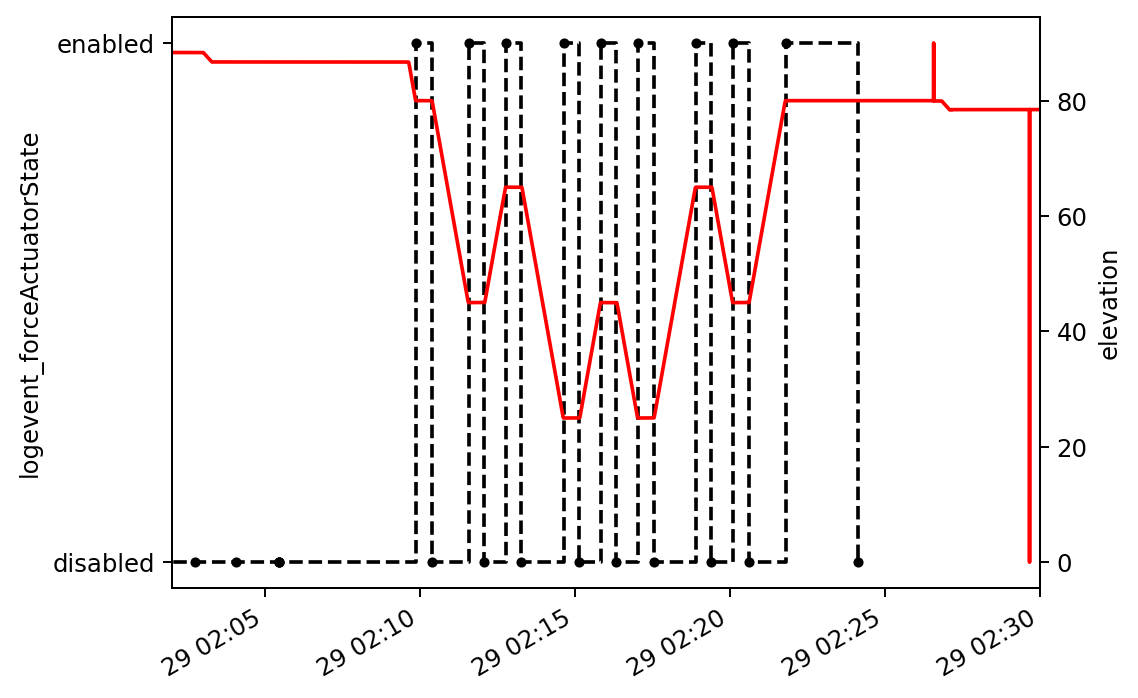

In [98]:
fig, ax=plt.subplots(dpi=175)
#ax.step(fa_state.index,fa_state["balanceForcesApplied"], ls="dashed", c="k", where="pre" )
ax.step(fa_state.index,fa_state["balanceForcesApplied"], ls="dashed", c="k", where="post" )
ax.scatter(fa_state.index,fa_state["balanceForcesApplied"], s=10, c="k")
ax.set_xlim(begin_t.datetime, end_t.datetime)
ax.set_yticks([0,1])
ax.set_yticklabels(["disabled", "enabled"])
ax.set_ylabel("logevent_forceActuatorState")

ax2=ax.twinx()
ax2.plot(df_mtmount_el.index, df_mtmount_el["actualPosition"], c="r")
ax2.set_ylabel("elevation")

fig.autofmt_xdate()


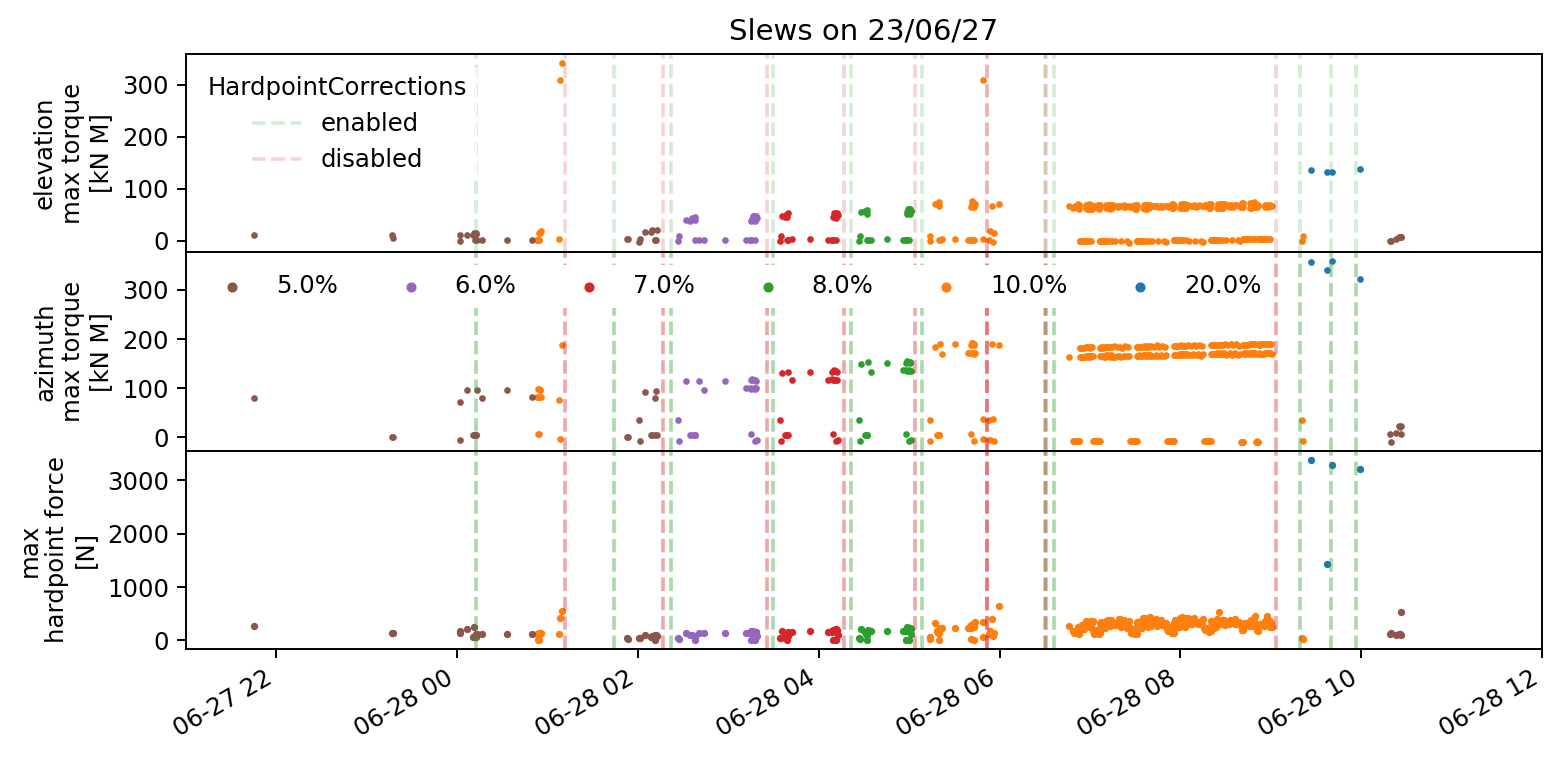

In [29]:
fig, axs=plt.subplots(3, figsize=(10,5), dpi=175, sharex=True)

ax=axs[0]
ax.set_title("Slews on 23/06/27")
for i in np.unique(slew_summary_frame["motion_state"])[::-1]:
    if np.isnan(i):
        continue
    sel=(slew_summary_frame["motion_state"]==i)
    ax.scatter(Time(slew_summary_frame["begin_slew"][sel], format="unix").datetime,  
               slew_summary_frame["max_torque_el"][sel]/1e3, s=3)
# ax.scatter(Time(slew_summary_frame["begin_slew"][~sel], format="unix").datetime,  
#            slew_summary_frame["max_torque_el"][~sel]/1e3, s=1)

for i in enables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, label="enabled", c="tab:green", ls="dashed", alpha=0.2)

for i in disables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, label="disabled", c="tab:red", ls="dashed", alpha=0.2)

#ax.set_yscale('log')
ax.set_ylabel("elevation\nmax torque\n[kN M]")
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
      if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels, title="HardpointCorrections", edgecolor="None")
#ax.legend(ncol=2, loc=2, title="hp balance forces")

ax=axs[1]

for i in enables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:green", ls="dashed", alpha=0.4)

for i in disables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:red", ls="dashed", alpha=0.4)



for i in np.unique(slew_summary_frame["motion_state"])[::-1]:
    if np.isnan(i):
        continue
    sel=(slew_summary_frame["motion_state"]==i)
    ax.scatter(Time(slew_summary_frame["begin_slew"][sel], format="unix").datetime,  
               slew_summary_frame["max_torque_az"][sel]/1e3, s=3, label=f"{i}%")

ax.set_ylabel("azimuth\nmax torque\n[kN M]")
ax.set_yticks(np.arange(0,400,100))
handles, labels = ax.get_legend_handles_labels()
lgnd=ax.legend(handles[::-1], labels[::-1],ncol=6, facecolor="White", edgecolor="None")
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes=[10]

lgnd.get_frame().set_alpha(1)
ax=axs[2]

for i in enables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:green", ls="dashed", alpha=0.4)

for i in disables["private_sndStamp"]:
    ax.axvline(Time(i, format="unix_tai").utc.datetime, c="tab:red", ls="dashed", alpha=0.4)

for i in np.unique(slew_summary_frame["motion_state"])[::-1]:
    if np.isnan(i):
        continue
    sel=(slew_summary_frame["motion_state"]==i)
    ax.scatter(Time(slew_summary_frame["begin_slew"][sel], format="unix").datetime, 
               slew_summary_frame["max_hp_force"][sel], s=4)
#ax.scatter(Time(slew_summary_frame["begin_slew"][~sel], format="unix").datetime, slew_summary_frame["max_hp_force"][~sel], s=1)
# ax.set_yscale('log')
ax.set_xlim(datetime(2023,6,27,21,0), datetime(2023,6,28,12,0))
ax.set_ylabel("max\nhardpoint force\n[N]")



plt.subplots_adjust(hspace=0)

fig.autofmt_xdate()

In [49]:
dat=pd.read_csv("./data/slew_summaries/slew_summary_frame_20230627.csv")

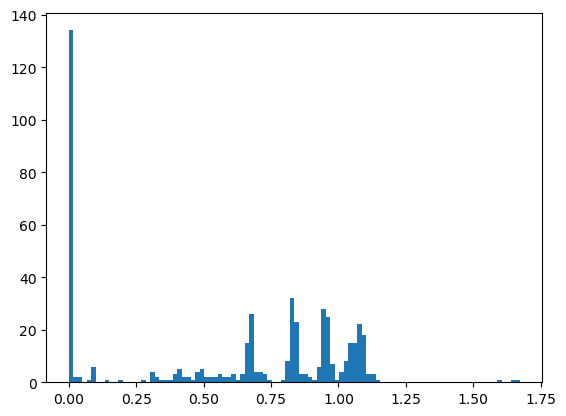

In [53]:
_=plt.hist(dat["max_acc_az"], bins=100)

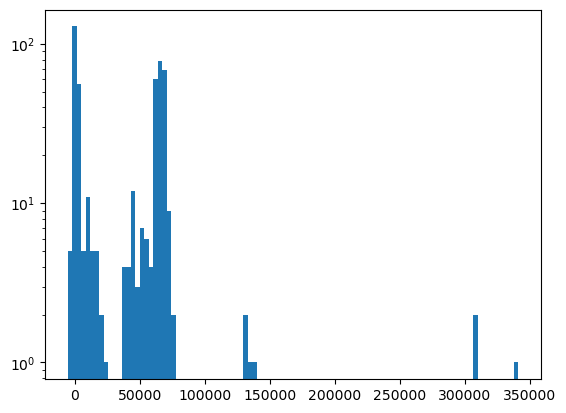

In [18]:
_=plt.hist(slew_summary_frame["max_torque_el"], bins=100)
plt.yscale('log')
plt.xticks(xticks,[f'{x:.2e}' for x in xticks])

In [22]:
delta_el=df_mtmount_el["actualPosition"][0] - df_mtmount_el["actualPosition"][-1]
delta_az=df_mtmount_az["actualPosition"][0] - df_mtmount_az["actualPosition"][-1]

In [36]:
maxima_hp=[]
for i in range(6):
    maxima_hp.append((df_m1m3_hardpoint[f"measuredForce{i}"].max(), i))
    maxima_hp.append((df_m1m3_hardpoint[f"measuredForce{i}"].min(), i))
maxima_hp=np.array(maxima_hp)

el_torque_max=df_mtmount_el["actualTorque"].max()

In [42]:
np.argmax(maxima_hp[:,0])#.max()

2

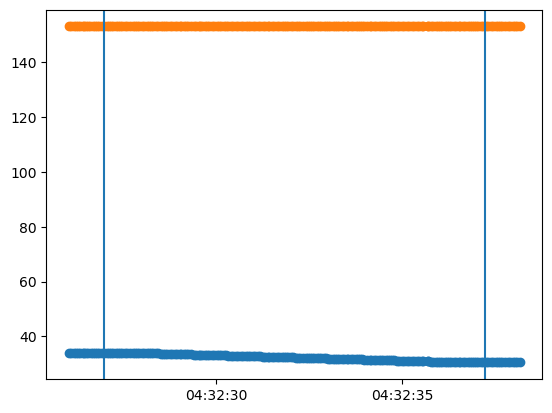

In [21]:
plt.scatter(Time(df_mtmount_el["private_sndStamp"], format="unix_tai").datetime, df_mtmount_el["actualPosition"])
plt.scatter(Time(df_mtmount_az["private_sndStamp"], format="unix_tai").datetime, df_mtmount_az["actualPosition"])
plt.axvline(slews[i_slew].begin.datetime)
plt.axvline(slews[i_slew].end.datetime)